# Demo of SpikeShip with neural data

A short example using [AllenSDK](https://alleninstitute.github.io/AllenSDK/install.html) and SpikeShip dissimilarity measure to find temporal spiking patterns in mice visual cortex.


We use Allen Brain Institute dataset as an application of the SpikeShip algorithm. The first step consists in build another dataset with epochs (i.e, trial, time window) and spike times. This new structure follows the work called "SPOTDis" (Grossberger L., et al.) .

It consists of two data-structures:

1) The spike times vector (e.g. `spike_times = [0.2, 0.6, 0.65, 0.9, 1.1, 0.3, 0.9, 0.2]`) of type float with one entry for each spike.

2) The index matrix with the dimensions (#epochs, #neurons, 2) of type int where the last dimension contains a start and a stop index for the spike times vector, indicating which spikes belong to the selected epoch and neuron.

ii_spike_times = [

    # Epoch 1    
    [
        # Neuron 1 -> spike(s) at time(s) 0.2, 0.6
        [0, 2],
        # Neuron 2 -> spike(s) at time(s) 0.65
        [2, 3],
        # Neuron 3 -> spike(s) at time(s) 0.9, 1.1
        [3, 5],
    ],
    
    # Epoch 2
    [
        # Neuron 1 -> spike(s) at time(s) 0.3
        [5, 6],
        # Neuron 2 -> spike(s) at time(s) 0.9
        [6, 7],
        # Neuron 3 -> spike(s) at time(s) 0.2
        [8, 9],
    ],
]

The spike times for a given epoch `e` and neuron `n` can be retrieved from the spike times vector using the index matrix as follows:
```epoch_neuron_spike_times = spike_times[ii_spike_times[e, n, 0]:ii_spike_times[e, n, 1]]
```

Check [SPOTDis Demo](https://github.com/LGro/spot/blob/master/notebooks/SPOTDisClust_Demo.ipynb) for more information.


## Importing libraries

In [1]:
# tools
import os

import numpy as np
import matplotlib.pyplot as plt

# warnings from jupyter notebook
import warnings
warnings.filterwarnings('ignore')

# distance computation
from spikeship import spikeship

# visualization
import hdbscan
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

---

## Reading data

In [2]:
spike_times    = np.load('../example_data/allen_nwb/spike_times.npy')
ii_spike_times = np.load('../example_data/allen_nwb/ii_spike_times.npy')
stim_labels    = np.load('../example_data/allen_nwb/stim_label.npy')

---
## SpikeShip
### Computation

In [26]:
%%time
# computation of neuron specific-flows
diss_spikeship, _ = spikeship.distances(spike_times, ii_spike_times)

CPU times: user 58 s, sys: 8.98 ms, total: 58 s
Wall time: 3.94 s


### Visualization

#### t-SNE Computation

In [27]:
tsne_model = TSNE(metric='precomputed', n_components=2)
emd_spikeship  = tsne_model.fit_transform(diss_spikeship)

#### Dissimilarity matrx of neuron-specific shifts and 2D t-SNE embedding

In [7]:
stim_values = np.unique(stim_labels)
stim_values

array([  0,  45,  90, 135])

<Figure size 432x288 with 0 Axes>

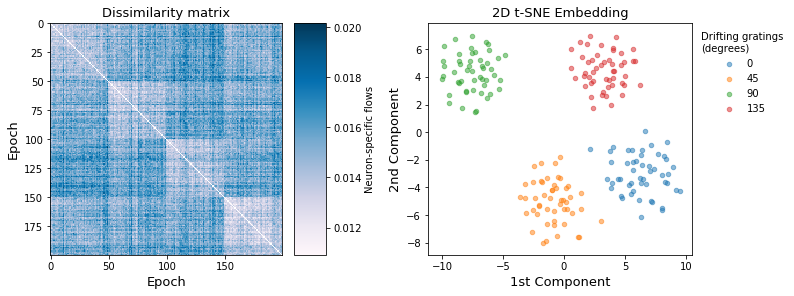

In [29]:
plt.clf()
fs = 13
alpha = 0.5
marker = 'o'
tPlot, axes = plt.subplots(
    figsize = (11,4),
    nrows=1, ncols=2, sharex=False, sharey=False, 
    constrained_layout=True
    )

# Dissimilarity matrix (vis)
axes[0].set_title('Dissimilarity matrix', fontsize=fs)
np.fill_diagonal(diss_spikeship, np.nan) # for visualization purposes
im0 = axes[0].imshow(diss_spikeship, cmap='PuBu')
axes[0].set_xlabel('Epoch', fontsize=fs)
axes[0].set_ylabel('Epoch', fontsize=fs);
plt.colorbar(im0, ax=axes[0], label='Neuron-specific flows')

# 2D tsne embedding (vis)
l_colors = ['royalblue', 'orange', 'green', 'purple']
for i in range(len(stim_values)):
    stim_val = stim_values[i]
    mask = (stim_labels == stim_val)
    axes[1].set_title('2D t-SNE Embedding', fontsize=fs)
    axes[1].scatter(emd_spikeship[mask, 0], emd_spikeship[mask, 1], s=20, alpha=0.5, label=stim_val)#, c=np.repeat(l_colors[i], np.sum(mask)), alpha=alpha, marker=marker, facecolors='none')
    axes[1].set_xlabel("1st Component", fontsize=fs); axes[1].set_ylabel("2nd Component", fontsize=fs)

_ = axes[1].legend(bbox_to_anchor=(1,1), frameon=False, title="Drifting gratings\n(degrees)")

---

## Comparison with SPOTDis
In order to test the SPOTDis module, follow the instructions in the github repository of its authors: https://github.com/LGro/spot/blob/master/notebooks/SPOTDisClust_Demo.ipynb.

In [9]:
from spot import spot

In [11]:
%%time
diss_spot = spot.distances(spike_times, ii_spike_times, metric='SPOTD_xcorr')

CPU times: user 8h 59min 10s, sys: 5.6 s, total: 8h 59min 16s
Wall time: 35min 16s


#### tSNE Computation

In [12]:
tsne_model = TSNE(metric='precomputed', n_components=2)
embedding_dis  = tsne_model.fit_transform(diss_spot)

<Figure size 432x288 with 0 Axes>

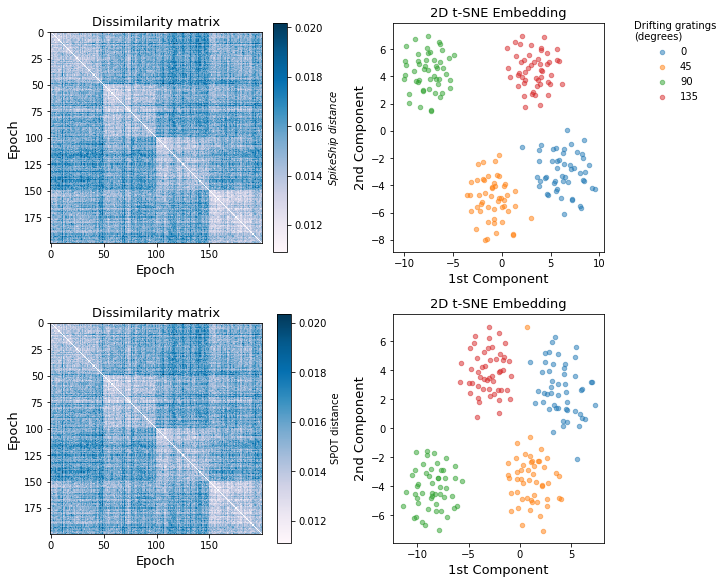

In [49]:
plt.clf()
alpha = 0.5
marker = 'o'
tPlot, axes = plt.subplots(
    figsize = (10,8),
    nrows=2, ncols=2, sharex=False, sharey=False, 
    constrained_layout=True
    )

# Dissimilarity matrices
axes[0][0].set_title('Dissimilarity matrix', fontsize=fs)
np.fill_diagonal(diss_spikeship, np.nan) # for visualization purposes
im0 = axes[0][0].imshow(diss_spikeship, cmap='PuBu')
axes[0][0].set_xlabel('Epoch', fontsize=fs)
axes[0][0].set_ylabel('Epoch', fontsize=fs);
plt.colorbar(im0, ax=axes[0][0], label='$SpikeShip\ distance$')

axes[1][0].set_title('Dissimilarity matrix', fontsize=fs)
np.fill_diagonal(diss_spot, np.nan) # for visualization purposes
im1 = axes[1][0].imshow(diss_spot, cmap='PuBu')
axes[1][0].set_xlabel('Epoch', fontsize=fs)
axes[1][0].set_ylabel('Epoch', fontsize=fs);
plt.colorbar(im1, ax=axes[1][0], label='SPOT distance')

# 2D tsne embedding (vis)
l_colors = ['royalblue', 'orange', 'green', 'purple']
for i in range(len(stim_values)):
    stim_val = stim_values[i]
    mask = (stim_labels == stim_val)
    axes[0][1].set_title('2D t-SNE Embedding', fontsize=fs)
    axes[0][1].scatter(emd_spikeship[mask, 0], emd_spikeship[mask, 1], s=20, alpha=0.5, label=stim_val)
    axes[0][1].set_xlabel("1st Component", fontsize=fs); 
    axes[0][1].set_ylabel("2nd Component", fontsize=fs);

    axes[1][1].set_title('2D t-SNE Embedding', fontsize=fs)
    axes[1][1].scatter(embedding_dis[mask, 0], embedding_dis[mask, 1], s=20, alpha=0.5, label=stim_val)
    axes[1][1].set_xlabel("1st Component", fontsize=fs); axes[1][1].set_ylabel("2nd Component", fontsize=fs)

axes[0][1].legend(bbox_to_anchor=(1.1, 1.05), frameon=False, title="Drifting gratings\n(degrees)")


In order to compute the dissimilarity between two pairs of epochs, SPOTDis has a computational complexity of $\mathcal{O}(N^2n^2)$, where $N$ is the number of active Neurons, and $n$ the average spikes per epoch. In contrast, SpikeShip has a computational complexity of $\mathcal{O}(Nn)$ (Quadratic speed-up).

---
Check out our paper for more details:

Sotomayor-Gómez, B., Battaglia, F. P., & Vinck, M. (2021). [SpikeShip: A method for fast, unsupervised discovery of high-dimensional neural spiking patterns](https://doi.org/10.1101/2020.06.03.131573). *bioRxiv*.

---